In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')

# Split data into fraud and legitimate
fraud_data = df[df['Class'] == 1]
legit_data = df[df['Class'] == 0]

# Split both classes into train and test (80/20)
fraud_train, fraud_test = train_test_split(fraud_data, test_size=0.3, random_state=42)
legit_train, legit_test = train_test_split(legit_data, test_size=0.3, random_state=42)

# Preserve test set for final evaluation
final_test_set = pd.concat([fraud_test, legit_test])

# GAN will only train on fraud TRAINING data
fraud_train_features = fraud_train.drop(columns=['Class']).values

# Normalize data using scaler fitted ONLY on fraud training data
scaler = MinMaxScaler()
fraud_train_scaled = scaler.fit_transform(fraud_train_features)

# Convert to PyTorch dataset
real_data = torch.tensor(fraud_train_scaled, dtype=torch.float32)
dataset = TensorDataset(real_data)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

In [9]:
# ========== WGAN-GP ARCHITECTURE ==========
class Generator(nn.Module):
    def __init__(self, z_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, output_dim),
            nn.Tanh()  # Changed to Tanh for better gradient flow
        )

    def forward(self, z):
        return self.model(z)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

In [10]:
# ========== WGAN-GP TRAINING ==========
# Parameters
input_dim = real_data.shape[1]
z_dim = 100                       # Increased latent dimension
epochs = 5000
n_critic = 5                      # Original paper recommendation
lambda_gp = 10                    # Increased gradient penalty weight
batch_size = 128

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(z_dim, input_dim).to(device)
critic = Critic(input_dim).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=0.00005, betas=(0.5, 0.9))

In [12]:
# Gradient penalty function
def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = critic(interpolates)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Enable cuDNN auto-tuner
torch.backends.cudnn.benchmark = True

# Initialize lists to store losses
g_losses = []
c_losses = []
gp_terms = []

for epoch in range(epochs):
    for i, batch in enumerate(data_loader):
        real_batch = batch[0].to(device)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(real_batch.size(0), z_dim, device=device)
            fake_batch = generator(z)

            real_validity = critic(real_batch)
            fake_validity = critic(fake_batch.detach())

            gradient_penalty = compute_gradient_penalty(critic, real_batch.data, fake_batch.data)
            c_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

            optimizer_C.zero_grad()
            c_loss.backward()
            optimizer_C.step()

        # Train Generator
        z = torch.randn(real_batch.size(0), z_dim, device=device)
        gen_batch = generator(z)
        g_loss = -torch.mean(critic(gen_batch))

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    # Save losses
    g_losses.append(g_loss.item())
    c_losses.append(c_loss.item())
    gp_terms.append(gradient_penalty.item())

    # Print progress
    if epoch % 200 == 0:
        print(f"Epoch {epoch}/{epochs} | C_loss: {c_loss.item():.4f} | GP: {gradient_penalty.item():.4f} | G_loss: {g_loss.item():.4f}")

Epoch 0/5000 | C_loss: 7.9395 | GP: 0.7935 | G_loss: -0.1311
Epoch 200/5000 | C_loss: 0.2676 | GP: 0.0060 | G_loss: -1.1986
Epoch 400/5000 | C_loss: 0.2240 | GP: 0.0035 | G_loss: -0.9288
Epoch 600/5000 | C_loss: 0.1709 | GP: 0.0048 | G_loss: -0.6321
Epoch 800/5000 | C_loss: 0.1753 | GP: 0.0217 | G_loss: 0.5182
Epoch 1000/5000 | C_loss: -0.0983 | GP: 0.0061 | G_loss: 1.0266
Epoch 1200/5000 | C_loss: -0.1826 | GP: 0.0036 | G_loss: 0.9611
Epoch 1400/5000 | C_loss: 0.3640 | GP: 0.0160 | G_loss: -0.9552
Epoch 1600/5000 | C_loss: 0.2688 | GP: 0.0048 | G_loss: -1.0001
Epoch 1800/5000 | C_loss: 0.1936 | GP: 0.0080 | G_loss: -0.4442
Epoch 2000/5000 | C_loss: 0.0942 | GP: 0.0203 | G_loss: 0.7506
Epoch 2200/5000 | C_loss: 0.2627 | GP: 0.0068 | G_loss: 0.2367
Epoch 2400/5000 | C_loss: 0.0076 | GP: 0.0118 | G_loss: 1.0309
Epoch 2600/5000 | C_loss: 0.1495 | GP: 0.0103 | G_loss: 0.6680
Epoch 2800/5000 | C_loss: 0.0887 | GP: 0.0101 | G_loss: 0.4822
Epoch 3000/5000 | C_loss: 0.0073 | GP: 0.0079 | G_los

In [14]:
# ========== SYNTHETIC DATA GENERATION ==========
generator.eval()
num_original_fraud_train = len(fraud_train)
num_legit_train = len(legit_train)
num_synthetic_needed = num_legit_train - num_original_fraud_train

synthetic_samples = []

with torch.no_grad():
    for _ in range(0, num_synthetic_needed, batch_size):
        batch_size_ = min(batch_size, num_synthetic_needed - len(synthetic_samples))
        z = torch.randn(batch_size_, z_dim, device=device)
        gen_samples = generator(z).cpu().numpy()
        synthetic_samples.extend(gen_samples)

# Convert to original scale
synthetic_samples = scaler.inverse_transform(synthetic_samples)
synthetic_fraud = pd.DataFrame(
    synthetic_samples,
    columns=fraud_train.drop(columns=['Class']).columns
)
synthetic_fraud['Class'] = 1

# Create balanced dataset
balanced_train = pd.concat([
    fraud_train,        # Original fraud
    legit_train,        # Original legit
    synthetic_fraud     # Synthetic fraud
], ignore_index=True)

# Shuffle the dataset
balanced_train = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Save datasets
balanced_train.to_csv('/content/drive/MyDrive/Colab Notebooks/balanced_creditcard_train.csv', index=False)
final_test_set.to_csv('/content/drive/MyDrive/Colab Notebooks/creditcard_test.csv', index=False)

In [15]:

print(f"Original fraud training samples: {len(fraud_train)}")
print(f"Synthetic fraud samples generated: {len(synthetic_fraud)}")
print(f"Balanced training set size: {len(balanced_train)}")
print(f"Test set size: {len(final_test_set)}")
print(f"Class distribution in training set:\n{balanced_train['Class'].value_counts()}")
print(f"Class distribution in testing set:\n{final_test_set['Class'].value_counts()}")

Original fraud training samples: 344
Synthetic fraud samples generated: 198676
Balanced training set size: 398040
Test set size: 85443
Class distribution in training set:
Class
0    199020
1    199020
Name: count, dtype: int64
Class distribution in testing set:
Class
0    85295
1      148
Name: count, dtype: int64


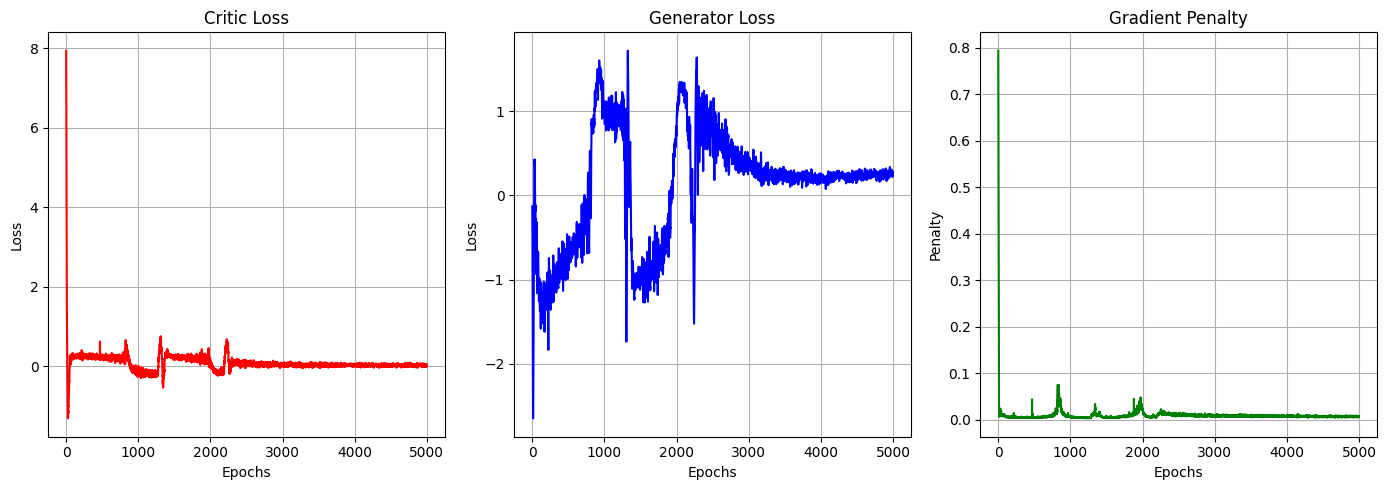

In [16]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(c_losses, label="Critic Loss", color='red')
plt.title("Critic Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.title("Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(gp_terms, label="Gradient Penalty", color='green')
plt.title("Gradient Penalty")
plt.xlabel("Epochs")
plt.ylabel("Penalty")
plt.grid(True)

plt.tight_layout()
plt.show()


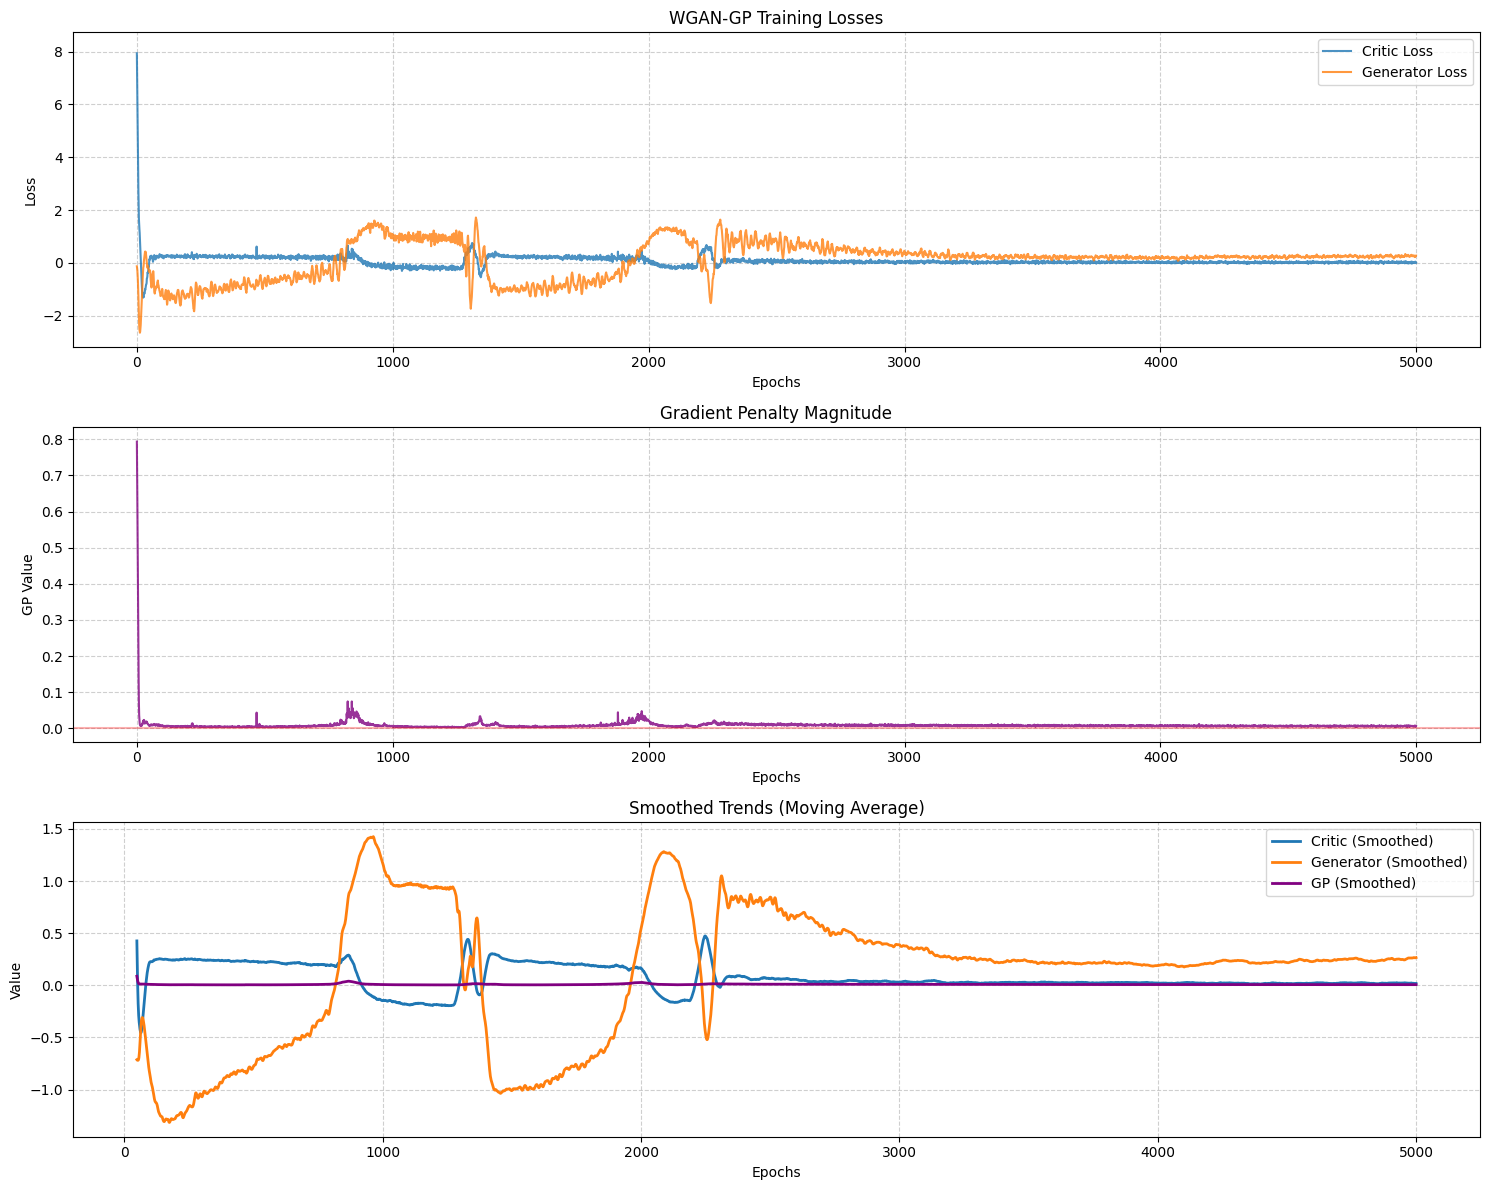

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots with 3 panels
plt.figure(figsize=(15, 12))

# 1. Critic vs Generator Loss
plt.subplot(3, 1, 1)
plt.plot(c_losses, label='Critic Loss', alpha=0.8, linewidth=1.5)
plt.plot(g_losses, label='Generator Loss', alpha=0.8, linewidth=1.5)
plt.title('WGAN-GP Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(min(min(c_losses), min(g_losses)) * 1.2, max(max(c_losses), max(g_losses)) * 1.1)  # Dynamic scaling

# 2. Gradient Penalty Term
plt.subplot(3, 1, 2)
plt.plot(gp_terms, color='purple', alpha=0.8, linewidth=1.5)
plt.title('Gradient Penalty Magnitude')
plt.xlabel('Epochs')
plt.ylabel('GP Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)  # Reference line at zero

# 3. Moving Averages (Smoothed Trends)
plt.subplot(3, 1, 3)
window_size = 50  # Adjust for smoothing sensitivity

# Calculate moving averages
c_smooth = np.convolve(c_losses, np.ones(window_size)/window_size, mode='valid')
g_smooth = np.convolve(g_losses, np.ones(window_size)/window_size, mode='valid')
gp_smooth = np.convolve(gp_terms, np.ones(window_size)/window_size, mode='valid')

# Plot smoothed curves
x_smooth = np.arange(window_size-1, len(c_losses))
plt.plot(x_smooth, c_smooth, label='Critic (Smoothed)', linewidth=2)
plt.plot(x_smooth, g_smooth, label='Generator (Smoothed)', linewidth=2)
plt.plot(x_smooth, gp_smooth, label='GP (Smoothed)', color='purple', linewidth=2)
plt.title('Smoothed Trends (Moving Average)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/wgan_training_metrics.png', dpi=300)
plt.show()

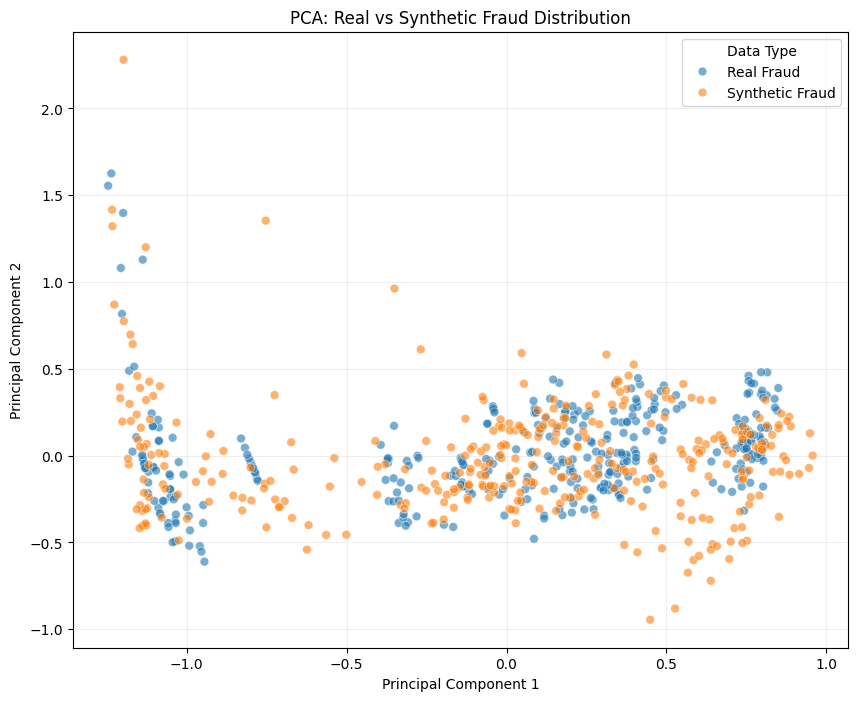

In [20]:
from sklearn.decomposition import PCA
import seaborn as sns

# Generate synthetic data (using your existing code)
generator.eval()
synthetic_samples = []
with torch.no_grad():
    for _ in range(0, num_synthetic_needed, batch_size):
        batch_size_ = min(batch_size, num_synthetic_needed - len(synthetic_samples))
        z = torch.randn(batch_size_, z_dim, device=device)
        synthetic_samples.extend(generator(z).cpu().numpy())

# Prepare data
real_samples = fraud_train_scaled
synth_samples = np.array(synthetic_samples)[:len(real_samples)]  # Match sizes

# Apply PCA
pca = PCA(n_components=2)
combined = np.vstack([real_samples, synth_samples])
pca_result = pca.fit_transform(combined)

# Create labels
labels = ['Real Fraud'] * len(real_samples) + ['Synthetic Fraud'] * len(synth_samples)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=labels,
    palette=['#1f77b4', '#ff7f0e'],
    alpha=0.6,
    s=40
)
plt.title('PCA: Real vs Synthetic Fraud Distribution')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Data Type')
plt.grid(alpha=0.2)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/pca_comparison.png', dpi=300)
plt.show()